In [1]:
import sys
import os
import psutil

import random
import math

import torch 
from torch import optim
from torch.optim import lr_scheduler
from torch import nn
from torch.nn import functional as F

import multiprocessing.dummy as mp

from pytorch_lightning import Trainer
from pytorch_lightning.core import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

sys.path.append('../..')
from lib.schedulers import DelayedScheduler
from lib.datasets import (max_lbl_nums, actual_lbl_nums, 
                          patches_rgb_mean_av1, patches_rgb_std_av1, 
                          get_train_test_img_ids_split)
from lib.dataloaders import PatchesDataset, WSIPatchesDatasetRaw
from lib.augmentations import augment_v1_clr_only, augment_empty_clr_only
from lib.losses import SmoothLoss

from lib.models.unetv1 import get_model

from sklearn.metrics import cohen_kappa_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
# import cv2
import numpy as np
# import pandas as pd
# from lib.datasets import patches_csv_path, patches_path
from lib.datasets import (patches_clean90_csv_path as patches_csv_path, patches_path,
                          patches_clean90_pkl_path as patches_pkl_path)
# from lib.dataloaders import imread, get_g_score_num, get_provider_num

In [12]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd
    def forward(self, x):
        return self.lambd(x)
    
def get_pretrained_model(get_model_fn, checkpoint, device):
    tmp = torch.load(checkpoint, map_location=device)
    
    model = get_model_fn(actual_lbl_nums)

    module = nn.Sequential()

    module.add_module('model', model)

    module.to(device);

    module.load_state_dict(tmp['state_dict'])

    model.segmentation = False
    model.classification_head = None
    model.autodecoder = None
    module.eval();
    
    return model

def get_features(imgs, features_batch_size=512):
    model.eval()
    
    imgs = imgs if isinstance(imgs, torch.Tensor) else torch.from_numpy(imgs)
    imgs = imgs.to(patches_device)
    n_imgs = (imgs - rgb_mean) / rgb_std
    
    b_features = []
    for b in range(0, n_imgs.shape[0], features_batch_size):
        with torch.no_grad():
            features, *_ = model(n_imgs[b:b+features_batch_size], return_features=True)
            b_features.append(features)

    features = torch.cat(b_features, dim=0)
    
    return features.cpu()

In [13]:
patches_device = torch.device('cuda:0')
# patches_device = torch.device('cpu')
main_device = torch.device('cuda:1')

In [14]:
model = get_pretrained_model(get_model, "../Patches256TestRun/version_0/checkpoints/last.ckpt", patches_device)

In [16]:
model = torch.jit.script(model)

RuntimeError: Can't redefine method: forward on class: __torch__.segmentation_models_pytorch.encoders.resnet.ResNetEncoder (addMethod at /opt/conda/conda-bld/pytorch_1579040055865/work/torch/csrc/jit/script/class_type.cpp:73)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x47 (0x7faa93886627 in /home/ruslan/anaconda3/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: c10::ClassType::addMethod(torch::jit::Function*) + 0x1d9 (0x7faa99219f69 in /home/ruslan/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #2: torch::jit::script::CompilationUnit::define(c10::optional<c10::QualifiedName> const&, torch::jit::script::Def const&, std::shared_ptr<torch::jit::script::Resolver> const&, torch::jit::script::Self const*, std::unordered_map<std::string, torch::jit::Function*, std::hash<std::string>, std::equal_to<std::string>, std::allocator<std::pair<std::string const, torch::jit::Function*> > > const&, bool) const + 0x6d7 (0x7faa991a6f47 in /home/ruslan/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #3: torch::jit::script::CompilationUnit::define(c10::optional<c10::QualifiedName> const&, std::vector<torch::jit::script::Def, std::allocator<torch::jit::script::Def> > const&, std::vector<std::shared_ptr<torch::jit::script::Resolver>, std::allocator<std::shared_ptr<torch::jit::script::Resolver> > > const&, torch::jit::script::Self const*, bool) + 0x17d (0x7faa991a768d in /home/ruslan/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #4: <unknown function> + 0x78ad7f (0x7faac4a55d7f in /home/ruslan/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #5: <unknown function> + 0x28ba06 (0x7faac4556a06 in /home/ruslan/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #6: _PyMethodDef_RawFastCallKeywords + 0x254 (0x555fd853f744 in /home/ruslan/anaconda3/bin/python)
frame #7: _PyCFunction_FastCallKeywords + 0x21 (0x555fd853f861 in /home/ruslan/anaconda3/bin/python)
frame #8: _PyEval_EvalFrameDefault + 0x52f8 (0x555fd85ab6e8 in /home/ruslan/anaconda3/bin/python)
frame #9: _PyFunction_FastCallKeywords + 0xfb (0x555fd853eccb in /home/ruslan/anaconda3/bin/python)
frame #10: _PyEval_EvalFrameDefault + 0x416 (0x555fd85a6806 in /home/ruslan/anaconda3/bin/python)
frame #11: _PyEval_EvalCodeWithName + 0xac9 (0x555fd84efd09 in /home/ruslan/anaconda3/bin/python)
frame #12: _PyFunction_FastCallKeywords + 0x387 (0x555fd853ef57 in /home/ruslan/anaconda3/bin/python)
frame #13: _PyEval_EvalFrameDefault + 0x416 (0x555fd85a6806 in /home/ruslan/anaconda3/bin/python)
frame #14: _PyFunction_FastCallKeywords + 0xfb (0x555fd853eccb in /home/ruslan/anaconda3/bin/python)
frame #15: _PyEval_EvalFrameDefault + 0x416 (0x555fd85a6806 in /home/ruslan/anaconda3/bin/python)
frame #16: _PyFunction_FastCallKeywords + 0xfb (0x555fd853eccb in /home/ruslan/anaconda3/bin/python)
frame #17: _PyEval_EvalFrameDefault + 0x4b39 (0x555fd85aaf29 in /home/ruslan/anaconda3/bin/python)
frame #18: _PyEval_EvalCodeWithName + 0x2f9 (0x555fd84ef539 in /home/ruslan/anaconda3/bin/python)
frame #19: _PyFunction_FastCallKeywords + 0x325 (0x555fd853eef5 in /home/ruslan/anaconda3/bin/python)
frame #20: _PyEval_EvalFrameDefault + 0x4b39 (0x555fd85aaf29 in /home/ruslan/anaconda3/bin/python)
frame #21: _PyEval_EvalCodeWithName + 0x2f9 (0x555fd84ef539 in /home/ruslan/anaconda3/bin/python)
frame #22: PyEval_EvalCodeEx + 0x44 (0x555fd84f0424 in /home/ruslan/anaconda3/bin/python)
frame #23: PyEval_EvalCode + 0x1c (0x555fd84f044c in /home/ruslan/anaconda3/bin/python)
frame #24: <unknown function> + 0x1daf8d (0x555fd85b5f8d in /home/ruslan/anaconda3/bin/python)
frame #25: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x555fd853f5d9 in /home/ruslan/anaconda3/bin/python)
frame #26: _PyCFunction_FastCallKeywords + 0x21 (0x555fd853f861 in /home/ruslan/anaconda3/bin/python)
frame #27: _PyEval_EvalFrameDefault + 0x47a4 (0x555fd85aab94 in /home/ruslan/anaconda3/bin/python)
frame #28: _PyGen_Send + 0x2a2 (0x555fd8548592 in /home/ruslan/anaconda3/bin/python)
frame #29: _PyEval_EvalFrameDefault + 0x1a79 (0x555fd85a7e69 in /home/ruslan/anaconda3/bin/python)
frame #30: _PyGen_Send + 0x2a2 (0x555fd8548592 in /home/ruslan/anaconda3/bin/python)
frame #31: _PyEval_EvalFrameDefault + 0x1a79 (0x555fd85a7e69 in /home/ruslan/anaconda3/bin/python)
frame #32: _PyGen_Send + 0x2a2 (0x555fd8548592 in /home/ruslan/anaconda3/bin/python)
frame #33: _PyMethodDef_RawFastCallKeywords + 0x8d (0x555fd853f57d in /home/ruslan/anaconda3/bin/python)
frame #34: _PyMethodDescr_FastCallKeywords + 0x4f (0x555fd85473cf in /home/ruslan/anaconda3/bin/python)
frame #35: _PyEval_EvalFrameDefault + 0x4c8c (0x555fd85ab07c in /home/ruslan/anaconda3/bin/python)
frame #36: _PyFunction_FastCallKeywords + 0xfb (0x555fd853eccb in /home/ruslan/anaconda3/bin/python)
frame #37: _PyEval_EvalFrameDefault + 0x416 (0x555fd85a6806 in /home/ruslan/anaconda3/bin/python)
frame #38: _PyFunction_FastCallKeywords + 0xfb (0x555fd853eccb in /home/ruslan/anaconda3/bin/python)
frame #39: _PyEval_EvalFrameDefault + 0x6a3 (0x555fd85a6a93 in /home/ruslan/anaconda3/bin/python)
frame #40: _PyEval_EvalCodeWithName + 0x2f9 (0x555fd84ef539 in /home/ruslan/anaconda3/bin/python)
frame #41: _PyFunction_FastCallDict + 0x400 (0x555fd84f0860 in /home/ruslan/anaconda3/bin/python)
frame #42: _PyObject_Call_Prepend + 0x63 (0x555fd850ee53 in /home/ruslan/anaconda3/bin/python)
frame #43: PyObject_Call + 0x6e (0x555fd8501dbe in /home/ruslan/anaconda3/bin/python)
frame #44: _PyEval_EvalFrameDefault + 0x1e42 (0x555fd85a8232 in /home/ruslan/anaconda3/bin/python)
frame #45: _PyEval_EvalCodeWithName + 0x5da (0x555fd84ef81a in /home/ruslan/anaconda3/bin/python)
frame #46: _PyFunction_FastCallKeywords + 0x387 (0x555fd853ef57 in /home/ruslan/anaconda3/bin/python)
frame #47: _PyEval_EvalFrameDefault + 0x14dc (0x555fd85a78cc in /home/ruslan/anaconda3/bin/python)
frame #48: <unknown function> + 0x16d059 (0x555fd8548059 in /home/ruslan/anaconda3/bin/python)
frame #49: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x555fd853f5d9 in /home/ruslan/anaconda3/bin/python)
frame #50: _PyCFunction_FastCallKeywords + 0x21 (0x555fd853f861 in /home/ruslan/anaconda3/bin/python)
frame #51: _PyEval_EvalFrameDefault + 0x47a4 (0x555fd85aab94 in /home/ruslan/anaconda3/bin/python)
frame #52: _PyEval_EvalCodeWithName + 0x5da (0x555fd84ef81a in /home/ruslan/anaconda3/bin/python)
frame #53: _PyFunction_FastCallKeywords + 0x387 (0x555fd853ef57 in /home/ruslan/anaconda3/bin/python)
frame #54: _PyEval_EvalFrameDefault + 0x6a3 (0x555fd85a6a93 in /home/ruslan/anaconda3/bin/python)
frame #55: <unknown function> + 0x16d059 (0x555fd8548059 in /home/ruslan/anaconda3/bin/python)
frame #56: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x555fd853f5d9 in /home/ruslan/anaconda3/bin/python)
frame #57: _PyCFunction_FastCallKeywords + 0x21 (0x555fd853f861 in /home/ruslan/anaconda3/bin/python)
frame #58: _PyEval_EvalFrameDefault + 0x47a4 (0x555fd85aab94 in /home/ruslan/anaconda3/bin/python)
frame #59: _PyEval_EvalCodeWithName + 0x5da (0x555fd84ef81a in /home/ruslan/anaconda3/bin/python)
frame #60: _PyFunction_FastCallKeywords + 0x387 (0x555fd853ef57 in /home/ruslan/anaconda3/bin/python)
frame #61: _PyEval_EvalFrameDefault + 0x416 (0x555fd85a6806 in /home/ruslan/anaconda3/bin/python)
frame #62: <unknown function> + 0x16d059 (0x555fd8548059 in /home/ruslan/anaconda3/bin/python)
frame #63: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x555fd853f5d9 in /home/ruslan/anaconda3/bin/python)


In [18]:
model.__class__.forward

<function segmentation_models_pytorch.encoders.resnet.ResNetEncoder.forward(self, x)>

In [ ]:
rgb_mean, rgb_std = (torch.tensor(patches_rgb_mean_av1, dtype=torch.float32, device=patches_device), 
                     torch.tensor(patches_rgb_std_av1, dtype=torch.float32, device=patches_device))

In [ ]:
train_img_ids, test_img_ids = get_train_test_img_ids_split()

test_img_ids[:4]

In [ ]:
dataset = WSIPatchesDatasetRaw(train_img_ids, patches_pkl_path, 
                               scale=0.5, transform=augment_v1_clr_only)

In [ ]:
process = psutil.Process(os.getpid())

In [ ]:
for _ in range(5):        
    memory = []

    main_batch_size = 64

    max_len = 300

    idxs = list(range(len(dataset)))
    random.shuffle(idxs)

    def process_item(idx):
        item_data = dataset[idx]
        return item_data

    b_features = torch.zeros((main_batch_size, max_len, 512, 8, 8), dtype=torch.float32)
    b_ys = torch.zeros((main_batch_size, max_len), dtype=torch.int64)
    b_xs = torch.zeros((main_batch_size, max_len), dtype=torch.int64)
    b_provider = torch.zeros((main_batch_size), dtype=torch.int64)
    b_isup_grade = torch.zeros((main_batch_size), dtype=torch.int64)
    b_gleason_score = torch.zeros((main_batch_size), dtype=torch.int64)

    batch = [b_features, b_ys, b_xs, b_provider, 
             b_isup_grade, b_gleason_score]

    def clean_batch():
        for a in batch:
            a.fill_(-1)

    clean_batch()

    c_iter = 0
    with mp.Pool(processes=6) as pool:
        for item_data in tqdm(pool.imap_unordered(process_item, idxs), total=len(dataset)):
        # for item_data in pool.imap_unordered(process_item, idxs):
            imgs, ys, xs, provider, isup_grade, gleason_score = item_data
            # imgs = torch.from_numpy(imgs).to(patches_device)
            features = get_features(imgs)

            b_iter = c_iter % main_batch_size
            p = ys.shape[0]

            b_features[b_iter, :p] = features[:max_len]
            b_ys[b_iter, :p] = torch.from_numpy(ys)[:max_len]        
            b_xs[b_iter, :p] = torch.from_numpy(xs)[:max_len]
            b_provider[b_iter] = provider
            b_isup_grade[b_iter] = isup_grade        
            b_gleason_score[b_iter] = gleason_score

            if (c_iter + 1) % main_batch_size == 0:
                #process batch
                #yield batch

                # clean batch data
                clean_batch()

            c_iter += 1

            memory.append(process.memory_info().rss)

    plt.axes().ticklabel_format(style='sci', scilimits=(9, 9))
    plt.plot(memory);
    plt.show()

In [10]:
class WSIPatchesDataloader():
    def __init__(self, dataset, batch_size=1, shuffle=False, num_workers=0, max_len=300):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.max_len = max_len
    
    def __len__(self):
        return math.ceil(len(self.dataset) / self.batch_size)
    
    def __iter__(self):
        return self.produce_batches()
    
    def produce_batches(self):
        def process_item(idx):
            item_data = self.dataset[idx]
            return item_data

        def clean_batch():
            for a in batch:
                a.fill_(-1)        
        
        idxs = list(range(len(self.dataset)))
        
        if self.shuffle:
            random.shuffle(idxs)
            
        max_len = self.max_len

        b_features = torch.zeros((main_batch_size, max_len, 512, 8, 8), dtype=torch.float32)
        b_ys = torch.zeros((main_batch_size, max_len), dtype=torch.int64)
        b_xs = torch.zeros((main_batch_size, max_len), dtype=torch.int64)
        b_provider = torch.zeros((main_batch_size), dtype=torch.int64)
        b_isup_grade = torch.zeros((main_batch_size), dtype=torch.int64)
        b_gleason_score = torch.zeros((main_batch_size), dtype=torch.int64)

        batch = [b_features, b_ys, b_xs, b_provider, 
                 b_isup_grade, b_gleason_score]

        clean_batch()

        c_iter = 0
        with mp.Pool(processes=self.num_workers) as pool:
            # for item_data in tqdm(pool.imap_unordered(process_item, idxs), total=len(dataset)):
            for item_data in pool.imap_unordered(process_item, idxs):
                imgs, ys, xs, provider, isup_grade, gleason_score = item_data
                features = get_features(imgs)

                b_iter = c_iter % main_batch_size
                p = ys.shape[0]

                b_features[b_iter, :p] = features[:max_len]
                b_ys[b_iter, :p] = torch.from_numpy(ys)[:max_len]        
                b_xs[b_iter, :p] = torch.from_numpy(xs)[:max_len]
                b_provider[b_iter] = provider
                b_provider[b_isup_grade] = isup_grade        
                b_provider[b_gleason_score] = gleason_score

                if (c_iter + 1) % main_batch_size == 0:
                    #process batch
                    yield batch

                    # clean batch data
                    clean_batch()

                c_iter += 1

        if c_iter % main_batch_size != 0:        
            yield [a[:c_iter % main_batch_size] for a in batch]

In [11]:
main_batch_size = 64

In [12]:
train_loader = WSIPatchesDataloader(WSIPatchesDatasetRaw(train_img_ids, patches_pkl_path, 
                                                         scale=0.5, transform=augment_v1_clr_only), 
                                    main_batch_size, shuffle=True, num_workers=6, max_len=300)

In [13]:
memory = []
for data in tqdm(train_loader, total=len(train_loader)):
    memory.append(process.memory_info().rss)

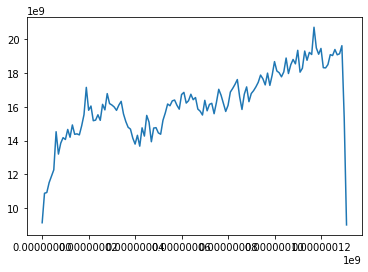

In [14]:
plt.axes().ticklabel_format(style='sci', scilimits=(9, 9))
plt.plot(memory);

In [15]:
memory = []
for data in tqdm(train_loader, total=len(train_loader)):
    memory.append(process.memory_info().rss)

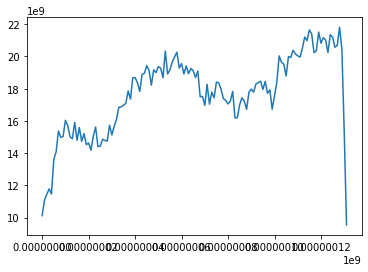

In [16]:
plt.axes().ticklabel_format(style='sci', scilimits=(9, 9))
plt.plot(memory);

In [17]:
memory = []
for data in tqdm(train_loader, total=len(train_loader)):
    memory.append(process.memory_info().rss)

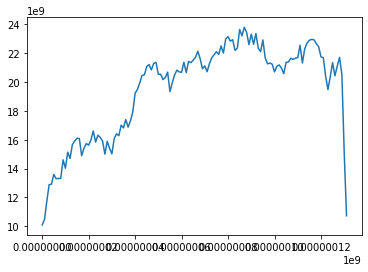

In [18]:
plt.axes().ticklabel_format(style='sci', scilimits=(9, 9))
plt.plot(memory);

In [10]:
def get_batches():
    main_batch_size = 64

    max_len = 300

    idxs = list(range(len(dataset)))
    random.shuffle(idxs)

    def process_item(idx):
        item_data = dataset[idx]
        return item_data

    b_features = torch.zeros((main_batch_size, max_len, 512, 8, 8), dtype=torch.float32)
    b_ys = torch.zeros((main_batch_size, max_len), dtype=torch.int64)
    b_xs = torch.zeros((main_batch_size, max_len), dtype=torch.int64)
    b_provider = torch.zeros((main_batch_size), dtype=torch.int64)
    b_isup_grade = torch.zeros((main_batch_size), dtype=torch.int64)
    b_gleason_score = torch.zeros((main_batch_size), dtype=torch.int64)

    batch = [b_features, b_ys, b_xs, b_provider, 
             b_isup_grade, b_gleason_score]

    def clean_batch():
        for a in batch:
            a.fill_(-1)

    clean_batch()

    c_iter = 0
    with mp.Pool(processes=6) as pool:
        # for item_data in tqdm(pool.imap_unordered(process_item, idxs), total=len(dataset)):
        for item_data in pool.imap_unordered(process_item, idxs):
            imgs, ys, xs, provider, isup_grade, gleason_score = item_data
            imgs = torch.from_numpy(imgs).to(patches_device)
            features = get_features(imgs)

            b_iter = c_iter % main_batch_size
            p = ys.shape[0]

            b_features[b_iter, :p] = features[:max_len]
            b_ys[b_iter, :p] = torch.from_numpy(ys)[:max_len]        
            b_xs[b_iter, :p] = torch.from_numpy(xs)[:max_len]
            b_provider[b_iter] = provider
            b_provider[b_isup_grade] = isup_grade        
            b_provider[b_gleason_score] = gleason_score

            if (c_iter + 1) % main_batch_size == 0:
                #process batch
                yield batch

                # clean batch data
                clean_batch()

            c_iter += 1

    if c_iter % main_batch_size != 0:        
        yield [a[:c_iter % main_batch_size] for a in batch]

In [12]:
memory = []
for data in tqdm(get_batches(), total=132):
    memory.append(process.memory_info().rss)

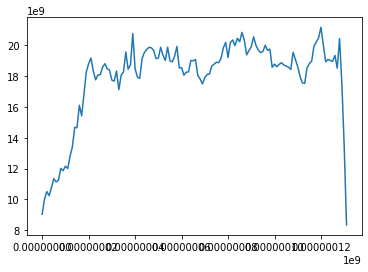

In [13]:
plt.axes().ticklabel_format(style='sci', scilimits=(9, 9))
plt.plot(memory);